# **Modelo Regresión Lineal para Proyecto de deforestación**

**Curso: 09481 - Inteligencia Artificial.**

**Universidad Icesi.**

**Profesor: Breyner Posso.**

**Estudiantes: Nicolas Colmenares, Nicolas Penagos, Juan Guapacha,Juan Pablo Sanin**

**Introducción**

En este enfoque del proyecto buscamos complementar el modelo basado en imágenes
a través de un dataset de deforestación en el Amazonas.

Para este trabajo se apoyó en recursos brindados por el profesor Breyner Posso y un proyecto de Salma B en Kaggle (https://www.kaggle.com/code/sbengali/brazilian-amazon-rainforest-degradation-analysis)

También se tuvo en cuenta el análisis exploratorio inicial a el dataset realizado en el la primera entrega del proyecto (https://colab.research.google.com/drive/17kdCZDov4ZNSWX57-aPcWJlLX150uf1h#scrollTo=2fCttZG0opEs)

Para este modelo se trabajaron con 2 archivos csv:
 
1.   Deforestación anual por regiones (def_area_2004_2019.csv)
2.   Incendios mensuales en región de 1999 a 2019 (inpe_brazilian_amazon_fires_1999_2019.csv)





## Librerías

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
import plotly.express as px
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor


## Datasets

In [2]:
deforest_df = pd.read_csv('def_area_2004_2019.csv')
fires_df =  pd.read_csv('inpe_brazilian_amazon_fires_1999_2019.csv')

In [ ]:
#En este primer data set se cuenta con el año y los kilometros cuadrados de deforestación por región
deforest_df.head()

,Ano/Estados,AC,AM,AP,MA,MT,PA,RO,RR,TO,AMZ LEGAL
0,2004,728,1232,46,755,11814,8870,3858,311,158,27772
1,2005,592,775,33,922,7145,5899,3244,133,271,19014
2,2006,398,788,30,674,4333,5659,2049,231,124,14286
3,2007,184,610,39,631,2678,5526,1611,309,63,11651
4,2008,254,604,100,1271,3258,5607,1136,574,107,12911


In [ ]:
# Tenemos 16 filas que hacen referencia a los años del 2004 a 2019
deforest_df.shape

(16, 11)

In [ ]:
'''
Para este dataset tenemos los meses de cada año, la región, sus coordenadas y 
la cantidad de incendios que se presentaron en ese mes
'''
fires_df.head()

,year,month,state,latitude,longitude,firespots
0,1999,1,AMAZONAS,-2.371113,-59.899933,3
1,1999,1,MARANHAO,-2.257395,-45.487831,36
2,1999,1,MATO GROSSO,-12.660633,-55.057989,18
3,1999,1,PARA,-2.474820,-48.546967,87
4,1999,1,RONDONIA,-12.861700,-60.513100,1


In [ ]:
# Tenemos 2104 registros desde 1999 a 2019
fires_df.shape

(2104, 6)

## Limpieza y exploración dataset deforestación

In [3]:
# Limpieza y cambio de nombres
deforest_df.drop(['AMZ LEGAL'], axis=1, inplace=True)
deforest_df.rename(columns={'Ano/Estados': 'Year',
                            'AC':'Acre', 
                            'AM':'Amazonas',
                            'AP':'Amapa', 
                            'MA':'Maranhao', 
                            'MT':'Mato Grosso', 
                            'PA':'Para',
                            'RO':'Rondonia', 
                            'RR':'Roraima', 
                            'TO':'Tocantins'}
                            , inplace=True)
deforest_df.head()

,Year,Acre,Amazonas,Amapa,Maranhao,Mato Grosso,Para,Rondonia,Roraima,Tocantins
0,2004,728,1232,46,755,11814,8870,3858,311,158
1,2005,592,775,33,922,7145,5899,3244,133,271
2,2006,398,788,30,674,4333,5659,2049,231,124
3,2007,184,610,39,631,2678,5526,1611,309,63
4,2008,254,604,100,1271,3258,5607,1136,574,107


In [4]:
#Agregamos columna con deforestación total
deforest_df['total_area'] = (deforest_df['Acre'] + 
                             deforest_df['Amazonas'] + 
                             deforest_df['Amapa'] + 
                             deforest_df['Maranhao'] + 
                             deforest_df['Mato Grosso'] + 
                             deforest_df['Para'] + 
                             deforest_df['Rondonia'] + 
                             deforest_df['Roraima'] + 
                             deforest_df['Tocantins'])
deforest_df.head()

,Year,Acre,Amazonas,Amapa,Maranhao,Mato Grosso,Para,Rondonia,Roraima,Tocantins,total_area
0,2004,728,1232,46,755,11814,8870,3858,311,158,27772
1,2005,592,775,33,922,7145,5899,3244,133,271,19014
2,2006,398,788,30,674,4333,5659,2049,231,124,14286
3,2007,184,610,39,631,2678,5526,1611,309,63,11651
4,2008,254,604,100,1271,3258,5607,1136,574,107,12911


In [35]:
deforest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Year         16 non-null     int64
 1   Acre         16 non-null     int64
 2   Amazonas     16 non-null     int64
 3   Amapa        16 non-null     int64
 4   Maranhao     16 non-null     int64
 5   Mato Grosso  16 non-null     int64
 6   Para         16 non-null     int64
 7   Rondonia     16 non-null     int64
 8   Roraima      16 non-null     int64
 9   Tocantins    16 non-null     int64
 10  total_area   16 non-null     int64
dtypes: int64(11)
memory usage: 1.5 KB


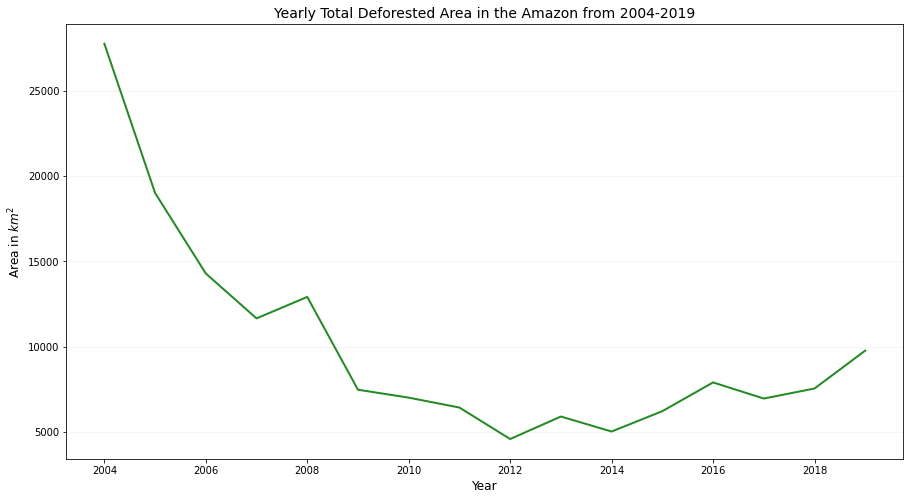

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
deforest_df.plot(x='Year', y='total_area',linewidth=2, 
                 legend=False, color='forestgreen', ax=ax)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Area in $km^2$', fontsize=12)
ax.set_title('Yearly Total Deforested Area in the Amazon from 2004-2019', fontsize=14)
ax.grid(axis='y', color='0.95')

El gráfico evidencia que el area de deforestación fue disminuyendo del 2004 al 2012, donde comenzó a aumentar de nuevo.

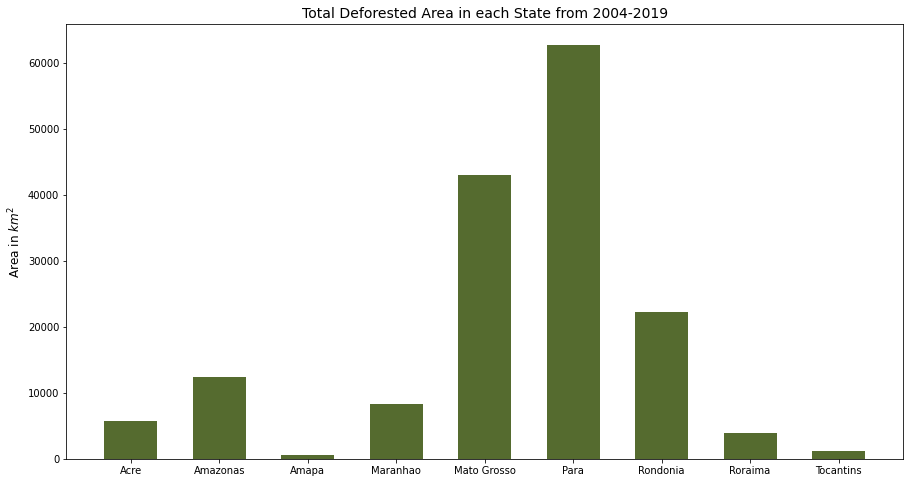

In [5]:
fig, ax = plt.subplots(figsize=(15,8))
states_def_df = deforest_df.append(deforest_df.sum(numeric_only=True), ignore_index=True)
states_def_df.drop(['Year', 'total_area'], axis=1, inplace=True)
bar_def = states_def_df.iloc[[-1]].squeeze().tolist()
states = ['Acre', 'Amazonas', 'Amapa', 'Maranhao', 'Mato Grosso', 'Para', 'Rondonia', 'Roraima', 'Tocantins']
ax.bar(states, bar_def, width=0.6, color='darkolivegreen')
ax.set_ylabel('Area in $km^2$', fontsize=12)
ax.set_title('Total Deforested Area in each State from 2004-2019', fontsize=14)
plt.show()

En cuanto a la deforestación total Para fue la región más afectada, seguida de Mato Grosso y Rondonia.

## Limpieza y exploración dataset incendios

In [ ]:
#Agregamos mayúsculas a las regiones
fires_df.state = [x.capitalize() for x in fires_df.state]

#agregamos meses
months= {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep',
             10:'Oct', 11:'Nov', 12:'Dec'}
fires_df['month_str'] = fires_df['month'].map(months)

fires_df.head()

,year,month,state,latitude,longitude,firespots,month_str
0,1999,1,Amazonas,-2.371113,-59.899933,3,Jan
1,1999,1,Maranhao,-2.257395,-45.487831,36,Jan
2,1999,1,Mato grosso,-12.660633,-55.057989,18,Jan
3,1999,1,Para,-2.474820,-48.546967,87,Jan
4,1999,1,Rondonia,-12.861700,-60.513100,1,Jan


In [ ]:
fig = px.scatter_geo(fires_df, lat='latitude',lon='longitude', color='state', 
                     hover_data=['state', 'year', 'month_str', 'firespots'], width=800, height=500)
fig.update_layout(title = 'Amazon Fire Outbreaks Map from 1999-2019', title_x=0.5, geo_scope='south america',
                 legend_title_text='State')
fig.show()

Generamos un gráfico interactivo donde se logran ver los incendios por cada región

In [ ]:
#Pivoteamos el dataset para obtener una estructura igual al de deforestación
fires_piv = pd.pivot_table(fires_df, values='firespots',index=['year'], columns=['state'], 
                     aggfunc=np.sum, fill_value=0)
fires_piv.head()

state,Acre,Amapa,Amazonas,Maranhao,Mato grosso,Para,Rondonia,Roraima,Tocantins
year,,,,,,,,,
1999,347,101,1048,4136,28538,20478,7121,220,869
2000,430,253,857,4500,17242,18201,5505,362,818
2001,829,1300,1297,7979,20795,28590,5062,2415,1408
2002,7985,3730,10203,20848,79680,106849,39132,2845,2601
2003,10523,2516,10191,12036,50713,53040,30533,3987,861


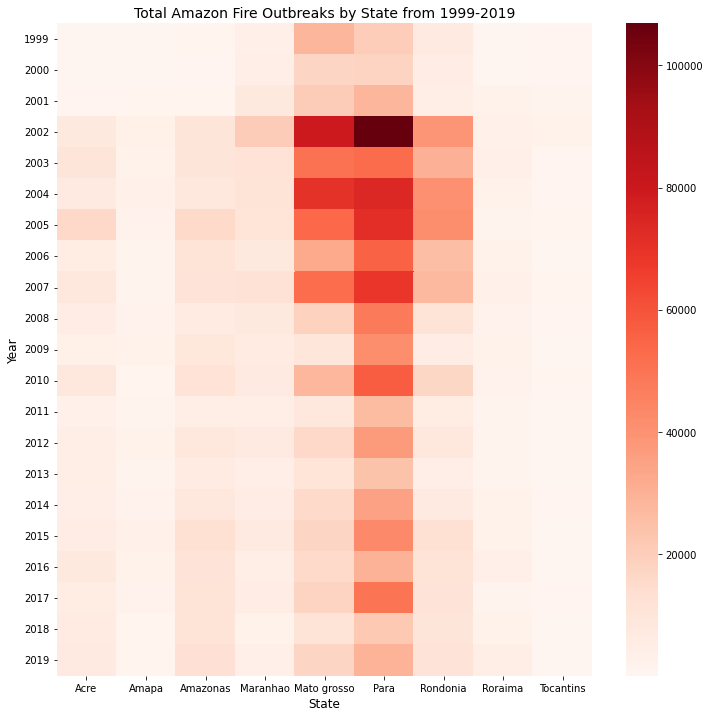

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(fires_piv, cmap='Reds')
ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Year', fontsize=12)
ax.set_title('Total Amazon Fire Outbreaks by State from 1999-2019', fontsize=14)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
plt.show()

Al generar un mapa de calor nos damos cuenta que en la región Para se presentan la incendios con frencuencias altas. Al igual que en Mato Groso y Rondonia pero en menor frecuencia. Se debe resaltar que se presenta el mismo orden que en el dataset de deforestación estableciendo un posible espacio para relación entre incendio y area deforestada.

Para validar esta relación se plantea dos gráficos del área deforestada y los incendios, al igual que una matriz de correlación

In [ ]:
#obtenemos el total de incendios por año
total_fires_piv = pd.pivot_table(fires_df, values='firespots',index=['year'], 
                     aggfunc=np.sum, fill_value=0)
total_fires_piv.head()

,firespots
year,
1999,62858
2000,48168
2001,69675
2002,273873
2003,174400


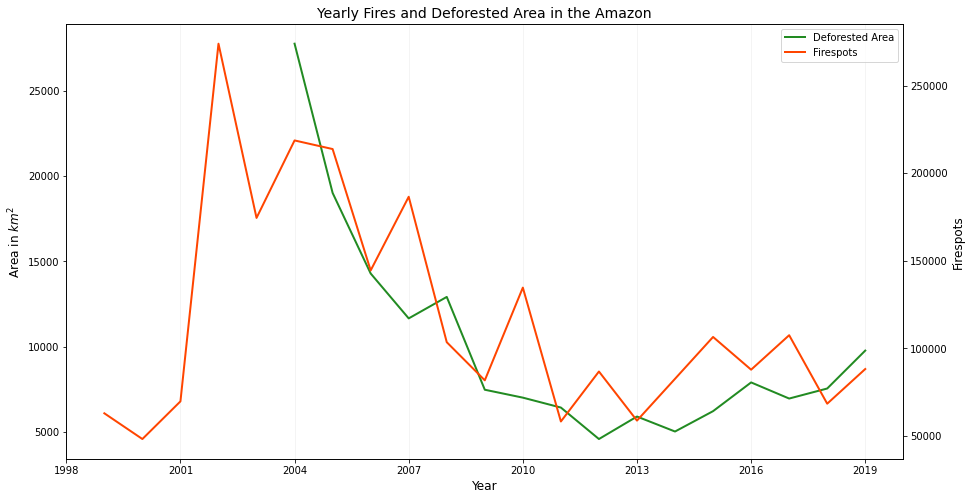

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Yearly Fires and Deforested Area in the Amazon', fontsize=14)
# Plot the total deforested area
deforest_df.plot(x='Year', y='total_area', 
                 linewidth=2, legend=False, color='forestgreen', ax=ax)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Area in $km^2$', fontsize=12)
ax.grid(axis='x', color='0.95')

# Plot the total number of firespots
ax2 = ax.twinx()
total_fires_piv.plot(linewidth=2, color='orangered', legend=False, ax=ax2)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylabel('Firespots', fontsize=12)

# Set the legend labels
line_labels = ['Deforested Area', 'Firespots']
handles = [plt.Line2D([0], [0], color='forestgreen', linewidth=2, label='Deforested Area')]
line_def = plt.Line2D([0], [0], color='orangered', linewidth=2, label='Deforested Area')
handles.append(line_def)
ax.legend(handles, line_labels)
plt.show()

A partir de este gráfico podemos decir que los incendios y el área deforestada tienen tendencias similares. Cuando hay un pico de incendios, años después se evidencia un aumento en área deforestada.

In [ ]:
# Remove fire data prior to 2004 to match with deforestation data
fires_df_filtered = fires_df[fires_df['year'] >= 2004]
state_fires_df = pd.pivot_table(fires_df_filtered, values='firespots',index=['state'], 
                                aggfunc=np.sum, fill_value=0)
state_fires_df['deforestation'] = bar_def
state_fires_df

,firespots,deforestation
state,,
Acre,106357,5722
Amapa,31437,12425
Amazonas,164887,616
Maranhao,111044,8318
Mato grosso,398410,43065
Para,715125,62778
Rondonia,253164,22279
Roraima,37152,3891
Tocantins,9697,1241


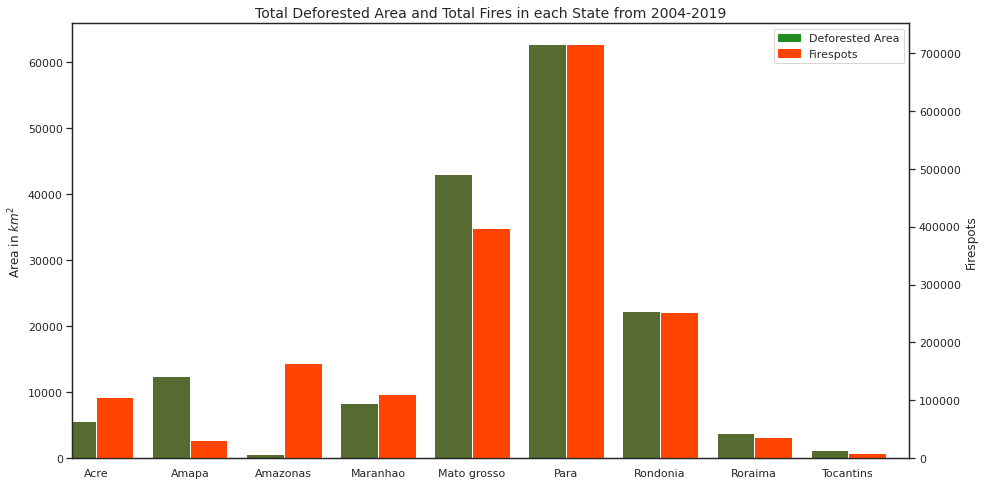

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# Plot data on a single X-axis
ax2 = ax.twinx()
state_fires_df.deforestation.plot(kind='bar', color='darkolivegreen', ax=ax, width=0.4, rot=0, position=1)
state_fires_df.firespots.plot(kind='bar', color='orangered', ax=ax2, width=0.4, rot=0, position=0)
ax.set_title('Total Deforested Area and Total Fires in each State from 2004-2019', fontsize=14)
ax.set_ylabel('Area in $km^2$', fontsize=12)
ax.set_xlabel('')
ax2.set_ylabel('Firespots', fontsize=12)
# Make a legend
bar_colors = {'Deforested Area': 'forestgreen', 'Firespots': 'orangered'}
bar_labels = ['Deforested Area', 'Firespots']
bar_handles = [plt.Rectangle((0,0),1,1,color=bar_colors[label]) for label in bar_labels]
ax.legend(bar_handles, bar_labels)
plt.show()

Al generar un gráfico donde se compara la cantidad de incendios con área deforestada se observan correlaciones altas para casi todas las regiones, entre más incendios mayor área deforestada. Sin embargo, Amapa y Amazonas no siguen esta tendencia. 

### Correlacion Incendio - Deforestaación

In [ ]:
#Para poder hacer las correlaciones primero debemos unificar los datasets

#Obtenemos valores de incendios
fires = total_fires_piv['firespots'].values
#eliminamos los años 1999 a 2003 para igualar los años
fires = np.delete(fires, [0, 1, 2, 3, 4])

#obtenemos los valores de deforestacion
deforest = deforest_df['total_area'].values

#obtenemos los años
years = deforest_df['Year'].values

#unimos y creamos el dataset
totals_df = pd.DataFrame({'Year': years, 'Fires': fires, 'Deforestation': deforest })

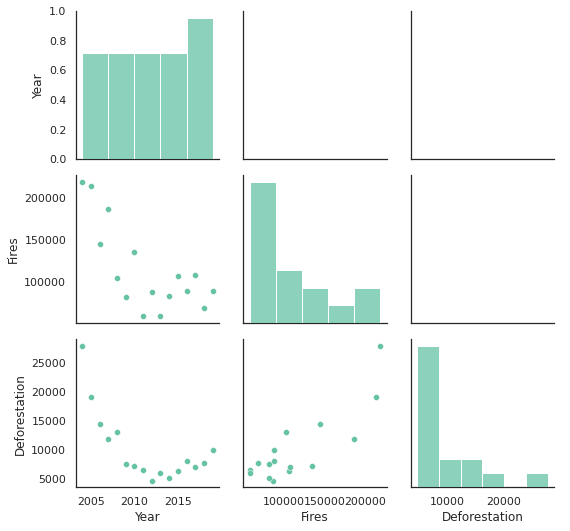

In [ ]:
#Gráfico de dispersión para ver cómo se comportan los datos

sns.set(style='white')
sns.set_palette('Set2')

g = sns.PairGrid(data=totals_df,diag_sharey=False, corner=False)

g.map_diag(sns.histplot) #Muestra el histograma en la diagonal principal.
g.map_lower(sns.scatterplot) #Muestra gráficos de dispersión en la sección inferior izquierda de la matriz.

g.add_legend()

plt.show()

En este gráfico podemos ver que tanto para incendios y deforestación se presenta una relacion negativa con el año. Por otro lado la relacion entre incendios y deforestación es positiva.

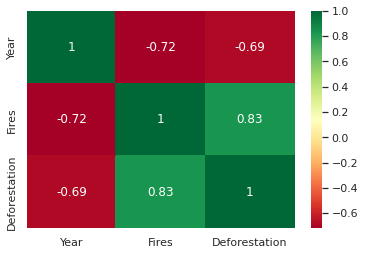

In [ ]:
ax = sns.heatmap(totals_df.corr(),annot=True,cmap='RdYlGn')

Al generar la matriz de correlación podemos ver que existe una relación positiva alta de 0.83 entre la cantidad de incendios y el área de deforestación. Al igual que una correlación negativa media-alta entre deforestación y año al igual que incendio y año. Es decir que en el tiempo se tiene una tendencia a disminuir en cuanto a incendios y deforestación

# Modelos de regresión lineal

## Funciones de apoyo 

In [6]:
#Función para generar modelos:

def linearRegressionGenerator(x_train,y_train, x_label, y_label, region):
  lin_reg_model = LinearRegression()
  
  lin_reg_model.fit(x_train,y_train)

  print("")
  print("----- "+region+" --------")
  print("")
  print('intercept [w0]=', lin_reg_model.intercept_)
  print('slope [wn]=', lin_reg_model.coef_)

 
  y_pred_train = lin_reg_model.predict(x_train)

  plt.scatter(x_train, y_train, label='Real')
  plt.plot(x_train,y_pred_train,'r', label='Predicted')
  plt.title(x_label+'VS'+y_label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

  r_sq = lin_reg_model.score(x_train, y_train)
  print('coefficient R^2 for training data: %.4f' % r_sq)
  print('coefficient R for training data: %.4f' % np.sqrt(r_sq))

  e_train = y_train - y_pred_train

  plt.scatter(y_pred_train,e_train)
  a = np.zeros(len(e_train))
  a = a.reshape(-1,1)
  plt.scatter(y_pred_train,a)
  plt.title('Training Data: Residuals vs Predicted values')
  plt.ylabel('Residuals')
  plt.xlabel('Predicted')
  plt.show()

  mse = metrics.mean_squared_error(y_train, y_pred_train)
  rmse = np.sqrt(mse)
  print('MSE= %.4f'% mse)
  print('RMSE: %.4f' % rmse)


## Modelos Zona - Año

In [7]:
x = deforest_df['Year'].values
x = x.reshape(-1, 1)


----- Acre --------

intercept [w0]= [5362.71029412]
slope [wn]= [[-2.48823529]]


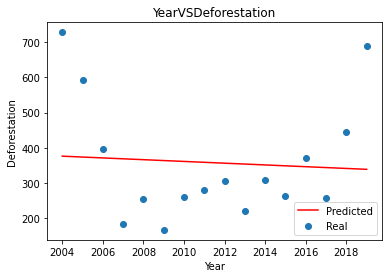

coefficient R^2 for training data: 0.0047
coefficient R for training data: 0.0687


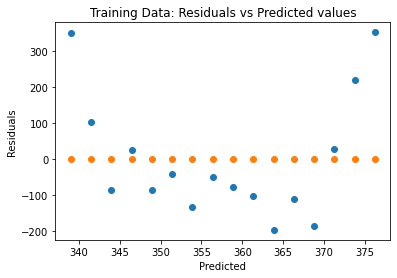

MSE= 27757.1689
RMSE: 166.6048

----- Amazonas --------

intercept [w0]= [-42337.57352941]
slope [wn]= [[21.43382353]]


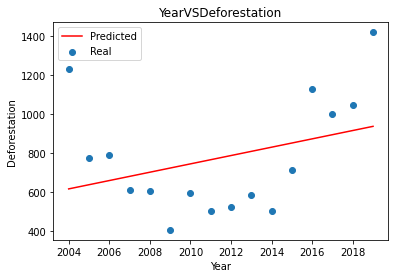

coefficient R^2 for training data: 0.1152
coefficient R for training data: 0.3394


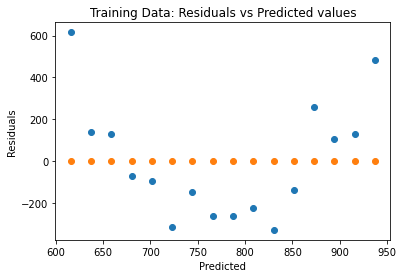

MSE= 74977.8093
RMSE: 273.8208

----- Amapa --------

intercept [w0]= [5363.05882353]
slope [wn]= [[-2.64705882]]


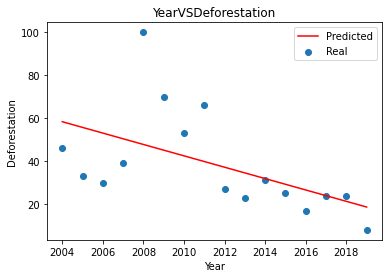

coefficient R^2 for training data: 0.2862
coefficient R for training data: 0.5350


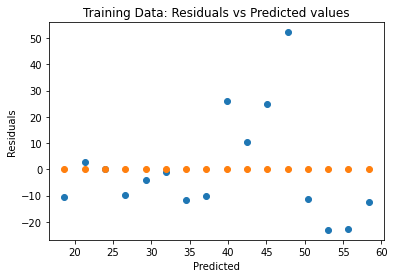

MSE= 371.3529
RMSE: 19.2705

----- Maranhao --------

intercept [w0]= [106999.21911765]
slope [wn]= [[-52.93529412]]


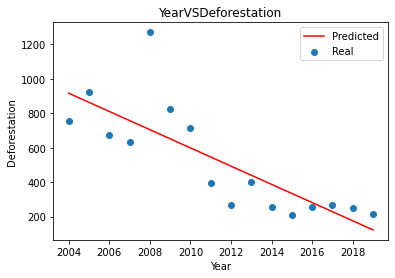

coefficient R^2 for training data: 0.6332
coefficient R for training data: 0.7958


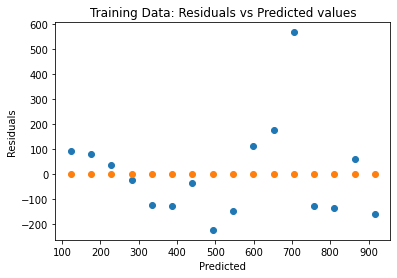

MSE= 34487.7704
RMSE: 185.7088

----- Mato Grosso --------

intercept [w0]= [824066.88088235]
slope [wn]= [[-408.33970588]]


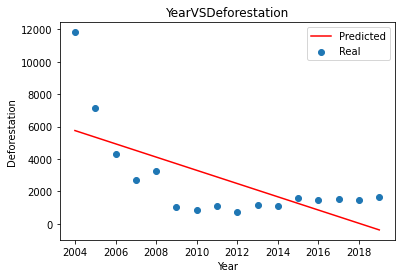

coefficient R^2 for training data: 0.4371
coefficient R for training data: 0.6612


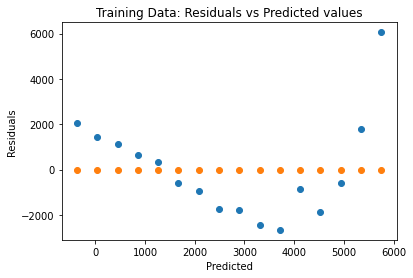

MSE= 4562148.5438
RMSE: 2135.9187

----- Para --------

intercept [w0]= [643207.90588235]
slope [wn]= [[-317.81470588]]


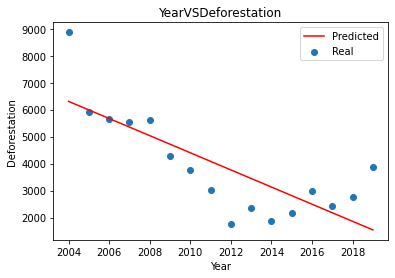

coefficient R^2 for training data: 0.6047
coefficient R for training data: 0.7776


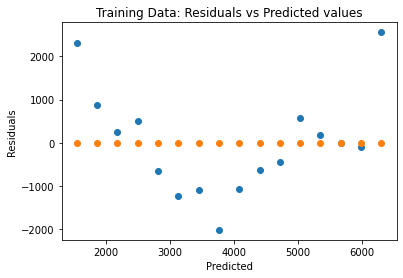

MSE= 1403131.6298
RMSE: 1184.5386

----- Rondonia --------

intercept [w0]= [219027.86323529]
slope [wn]= [[-108.19558824]]


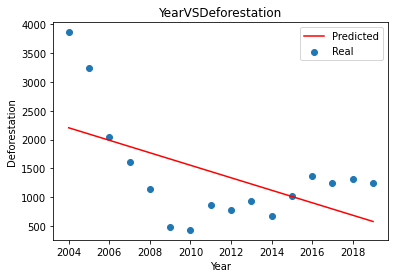

coefficient R^2 for training data: 0.2980
coefficient R for training data: 0.5459


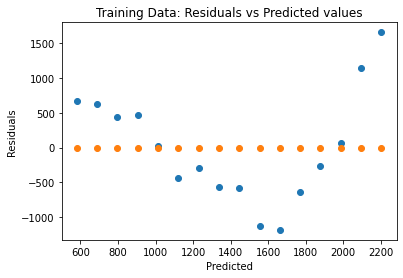

MSE= 585915.9332
RMSE: 765.4515

----- Roraima --------

intercept [w0]= [-1629.28235294]
slope [wn]= [[0.93088235]]


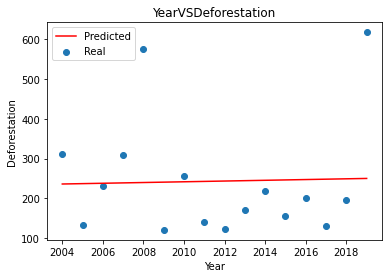

coefficient R^2 for training data: 0.0009
coefficient R for training data: 0.0294


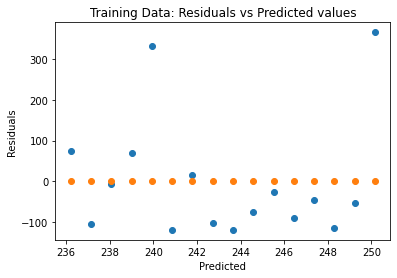

MSE= 21235.2383
RMSE: 145.7232

----- Tocantins --------

intercept [w0]= [19716.31029412]
slope [wn]= [[-9.76323529]]


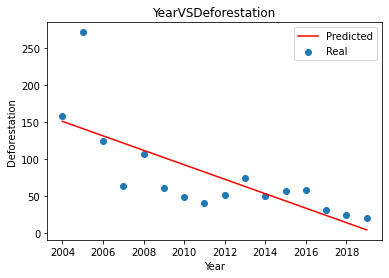

coefficient R^2 for training data: 0.5403
coefficient R for training data: 0.7350


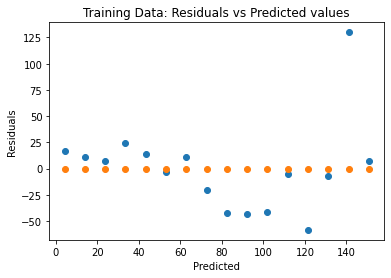

MSE= 1723.5549
RMSE: 41.5157


In [ ]:
for col in states:
    y = deforest_df[col].values
    y = y.reshape(-1, 1)
    linearRegressionGenerator(x,y,"Year", "Deforestation", col)

####Lasso

In [ ]:
for col in states:
    y = deforest_df[col].values
    y = y.reshape(-1, 1)
    lasso = Lasso()
    alphas = np.arange(0.001, 10, 0.001)

    tuned_parameters = [{"alpha": alphas}]
    n_folds = 10

    clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring = 'neg_root_mean_squared_error',refit=True)
    clf.fit(x, y)
    score = np.mean(abs(clf.cv_results_["mean_test_score"]))
    score_std = np.mean(abs(clf.cv_results_["std_test_score"]))
    print('best params for {} state are {}, with rmse of {} and deviation of {}'
    .format(col,clf.best_params_,score,score_std))


best params for Acre state are {'alpha': 9.998999999999999}, with rmse of 183.783789656014 and deviation of 149.2856528109224
best params for Amazonas state are {'alpha': 0.001}, with rmse of 311.3698167897144 and deviation of 188.14752612188792
best params for Amapa state are {'alpha': 0.243}, with rmse of 17.136225158229987 and deviation of 13.996893477440572
best params for Maranhao state are {'alpha': 9.998999999999999}, with rmse of 156.64634589510635 and deviation of 123.35475921755935
best params for Mato Grosso state are {'alpha': 9.998999999999999}, with rmse of 2223.8132792390093 and deviation of 1772.2125401374187
best params for Para state are {'alpha': 9.998999999999999}, with rmse of 1221.9614312622227 and deviation of 915.0684983484351
best params for Rondonia state are {'alpha': 9.998999999999999}, with rmse of 832.1407556051255 and deviation of 596.6829077598105
best params for Roraima state are {'alpha': 9.998999999999999}, with rmse of 140.41918749133598 and deviatio

####Ridge

In [ ]:
for col in states:
    y = deforest_df[col].values
    y = y.reshape(-1, 1)
    ridge = Ridge()

    alphas = np.arange(0.1, 100, 0.1)
    solvers = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']

    tuned_parameters = [{"alpha": alphas,"solver": solvers}]
    n_folds = 10

    clf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, scoring = 'neg_root_mean_squared_error',refit=True)
    clf.fit(x, y)
    score = np.mean(abs(clf.cv_results_["mean_test_score"]))
    score_std = np.mean(abs(clf.cv_results_["std_test_score"]))
    print('best params for {} state are {}, with rmse of {} and deviation of {}'
    .format(col,clf.best_params_,score,score_std))    

best params for Acre state are {'alpha': 72.6, 'solver': 'sag'}, with rmse of 179.5224707684784 and deviation of 142.89745827019019
best params for Amazonas state are {'alpha': 98.5, 'solver': 'saga'}, with rmse of 308.7860201119428 and deviation of 175.61617100054693
best params for Amapa state are {'alpha': 43.800000000000004, 'solver': 'saga'}, with rmse of 16.930984834188408 and deviation of 13.705890293901703
best params for Maranhao state are {'alpha': 99.9, 'solver': 'saga'}, with rmse of 143.46883316332472 and deviation of 135.76042472986387
best params for Mato Grosso state are {'alpha': 94.7, 'solver': 'sag'}, with rmse of 2039.560037484396 and deviation of 1865.9183245709066
best params for Para state are {'alpha': 65.89999999999999, 'solver': 'sag'}, with rmse of 1175.9862824043362 and deviation of 912.0747657322837
best params for Rondonia state are {'alpha': 75.2, 'solver': 'sag'}, with rmse of 785.3282487818434 and deviation of 607.8122191935555
best params for Roraima s

####Decision tree

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for col in states:
    y = deforest_df[col].values
    y = y.reshape(-1, 1)
    alpha = 0.003
    dt_regressor_model = DecisionTreeRegressor()
    dt_regressor_model.fit(x[:12], y[:12])
    y_pred = dt_regressor_model.predict(x[12:])
    print('Validation for state',col)
    score = r2_score(y[12:], y_pred)
    print('R^2: %.4f' % score)
    mse = mean_squared_error(y[12:], y_pred)
    rmse = np.sqrt(mse)
    print('MSE: %.4f'% mse)
    print('RMSE: %.4f' % rmse)

Validation for state Acre
R^2: -1.2471
MSE: 55972.2500
RMSE: 236.5846
Validation for state Amazonas
R^2: -7.1321
MSE: 217745.0000
RMSE: 466.6315
Validation for state Amapa
R^2: -1.0550
MSE: 88.7500
RMSE: 9.4207
Validation for state Maranhao
R^2: -3.9968
MSE: 1877.2500
RMSE: 43.3272
Validation for state Mato Grosso
R^2: -0.3140
MSE: 8380.2500
RMSE: 91.5437
Validation for state Para
R^2: -2.5864
MSE: 1013070.7500
RMSE: 1006.5142
Validation for state Rondonia
R^2: -23.0133
MSE: 73276.5000
RMSE: 270.6963
Validation for state Roraima
R^2: -0.4584
MSE: 54183.5000
RMSE: 232.7735
Validation for state Tocantins
R^2: -2.5903
MSE: 749.2500
RMSE: 27.3724


####Random Forest

In [11]:
import joblib

In [12]:
for col in states:
    y = deforest_df[col].values
    y = y.reshape(-1, 1)
    rf_regressor_model = RandomForestRegressor()
    rf_regressor_model.fit(x, y)
    y_pred = rf_regressor_model.predict(x)
    print('Validation for state',col)
    score = r2_score(y, y_pred)
    print('R^2: %.4f' % score)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    print('MSE: %.4f'% mse)
    print('RMSE: %.4f' % rmse)
    joblib.dump(rf_regressor_model,col+'_model.joblib')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Validation for state Acre
R^2: 0.9225
MSE: 2161.3592
RMSE: 46.4904
Validation for state Amazonas
R^2: 0.9291
MSE: 6008.3852
RMSE: 77.5138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Validation for state Amapa
R^2: 0.9085
MSE: 47.5953
RMSE: 6.8989
Validation for state Maranhao
R^2: 0.9457
MSE: 5104.3937
RMSE: 71.4450


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Validation for state Mato Grosso
R^2: 0.9583
MSE: 337597.3893
RMSE: 581.0313
Validation for state Para
R^2: 0.9622
MSE: 134160.0380
RMSE: 366.2786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Validation for state Rondonia
R^2: 0.9726
MSE: 22836.4471
RMSE: 151.1173
Validation for state Roraima
R^2: 0.8190
MSE: 3847.7192
RMSE: 62.0300
Validation for state Tocantins
R^2: 0.9200
MSE: 299.7819
RMSE: 17.3142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


## Total deforestación -Año


----- Total Area --------

intercept [w0]= [1779777.09264706]
slope [wn]= [[-879.81911765]]


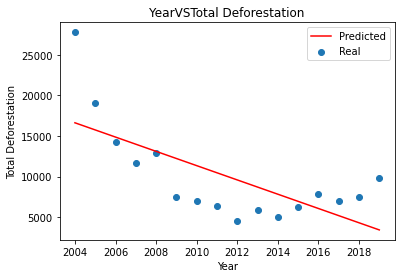

coefficient R^2 for training data: 0.4696
coefficient R for training data: 0.6853


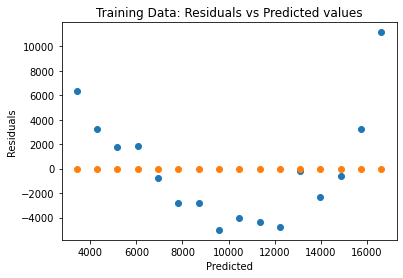

MSE= 18577877.8633
RMSE: 4310.2062


In [ ]:
y = deforest_df["total_area"].values
y = y.reshape(-1, 1)
linearRegressionGenerator(x,y,"Year", "Total Deforestation", "Total Area")

####Lasso

In [ ]:
lasso = Lasso()
alphas = np.arange(0.001, 10, 0.001)
tuned_parameters = [{"alpha": alphas}]
n_folds = 10

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring = 'neg_root_mean_squared_error',refit=True)
clf.fit(x, y)
score = np.mean(abs(clf.cv_results_["mean_test_score"]))
score_std = np.mean(abs(clf.cv_results_["std_test_score"]))
print('best params are {}, with rmse of {} and deviation of {}'
.format(clf.best_params_,score,score_std))

best params are {'alpha': 9.998999999999999}, with rmse of 4720.133493205786 and deviation of 3324.3363067747373


####Ridge

In [ ]:
ridge = Ridge()
alphas = np.arange(0.1, 100, 0.1)
solvers = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
tuned_parameters = [{"alpha": alphas,"solver": solvers}]
n_folds = 10

clf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, scoring = 'neg_root_mean_squared_error',refit=True)
clf.fit(x, y)
score = np.mean(abs(clf.cv_results_["mean_test_score"]))
score_std = np.mean(abs(clf.cv_results_["std_test_score"]))
print('best params are {}, with rmse of {} and deviation of {}'
.format(clf.best_params_,score,score_std))  

best params are {'alpha': 89.2, 'solver': 'saga'}, with rmse of 4365.862849976969 and deviation of 3513.1207474789726


####Decision tree

In [15]:
alpha = 0.003
dt_regressor_model = DecisionTreeRegressor()
dt_regressor_model.fit(x[:12], y[:12])
y_pred = dt_regressor_model.predict(x[12:])
print('Validation')
score = r2_score(y[12:], y_pred)
print('R^2: %.4f' % score)
mse = mean_squared_error(y[12:], y_pred)
rmse = np.sqrt(mse)
print('MSE: %.4f'% mse)
print('RMSE: %.4f' % rmse)

Validation
R^2: -2.5903
MSE: 749.2500
RMSE: 27.3724


####Random Forest

In [23]:
rf_regressor_model = RandomForestRegressor()
rf_regressor_model.fit(x, y)
y_pred = rf_regressor_model.predict(x)
print('Validation')
score = r2_score(y, y_pred)
print('R^2: %.4f' % score)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print('MSE: %.4f'% mse)
print('RMSE: %.4f' % rmse)

Validation
R^2: 0.9275
MSE: 271.9673
RMSE: 16.4914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [34]:
joblib.dump(dt_regressor_model,'brazil_model.joblib')

['brazil_model.joblib']

## Incendios - Deforestación


----- Totals --------

intercept [w0]= [-1235.86763777]
slope [wn]= [[0.09856704]]


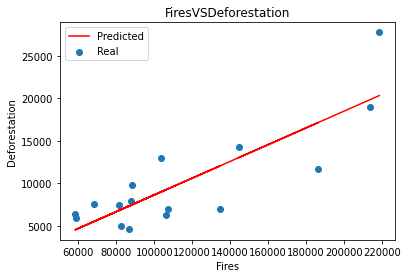

coefficient R^2 for training data: 0.6952
coefficient R for training data: 0.8338


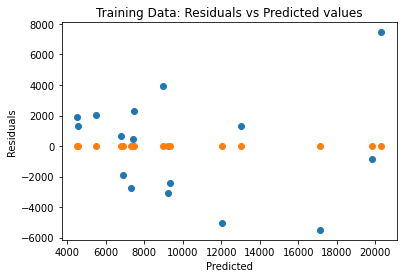

MSE= 10676766.1307
RMSE: 3267.5321


In [ ]:
x = totals_df["Fires"].values
y = totals_df["Deforestation"].values

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

linearRegressionGenerator(x,y,"Fires", "Deforestation", "Totals")

####Lasso

In [ ]:
lasso = Lasso()
alphas = np.arange(0.001, 10, 0.001)
tuned_parameters = [{"alpha": alphas}]
n_folds = 10

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring = 'neg_root_mean_squared_error',refit=True)
clf.fit(x, y)
score = np.mean(abs(clf.cv_results_["mean_test_score"]))
score_std = np.mean(abs(clf.cv_results_["std_test_score"]))
print('best params are {}, with rmse of {} and deviation of {}'
.format(clf.best_params_,score,score_std))

best params are {'alpha': 0.001}, with rmse of 3535.6648320840236 and deviation of 2521.3379875342375


####Ridge

In [ ]:
ridge = Ridge()
alphas = np.arange(0.1, 100, 0.1)
solvers = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']

tuned_parameters = [{"alpha": alphas,"solver": solvers}]
n_folds = 10

clf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, scoring = 'neg_root_mean_squared_error',refit=True)
clf.fit(x, y)
score = np.mean(abs(clf.cv_results_["mean_test_score"]))
score_std = np.mean(abs(clf.cv_results_["std_test_score"]))
print('best params are {}, with rmse of {} and deviation of {}'
.format(clf.best_params_,score,score_std))

best params are {'alpha': 42.6, 'solver': 'sag'}, with rmse of 3536.2238091834165 and deviation of 2521.289231862885


####Decision tree

In [ ]:
alpha = 0.003
dt_regressor_model = DecisionTreeRegressor()
dt_regressor_model.fit(x, y)
y_pred = dt_regressor_model.predict(x)
print('Validation')
score = r2_score(y, y_pred)
print('R^2: %.4f' % score)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print('MSE: %.4f'% mse)
print('RMSE: %.4f' % rmse)

Validation
R^2: 1.0000
MSE: 0.0000
RMSE: 0.0000


####Random Forest

In [ ]:
rf_regressor_model = RandomForestRegressor()
rf_regressor_model.fit(x, y)
y_pred = rf_regressor_model.predict(x)
print('Validation')
score = r2_score(y, y_pred)
print('R^2: %.4f' % score)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print('MSE: %.4f'% mse)
print('RMSE: %.4f' % rmse)

Validation
R^2: 0.8980
MSE: 3572080.1203
RMSE: 1889.9947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


## Conclusiones